# Master Project

**Set up**

In [2]:
### import libraries

#import tensorflow as tf
import tensorflow.compat.v1 as tf # code was written in old version of tensor flow
tf.disable_v2_behavior()
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
import math
from tqdm import tqdm_notebook

# representation of real numbers in TF, change here for 32/64 bits
real_type = tf.float32
# real_type = tf.float64

Instructions for updating:
non-resource variables are not supported in the long term


**Black Scholes**

In this implementation we assume the risk-free rate is zero for simplicity, which leads to simplified formulas under Black Scholes. 

Option value/price:
$$ C_t = S_t*N(d_1) - K*N(d_2)$$,

where $N()$ denotes the standard normal CDF and

$$ d_1 = (log(\frac{S_t}{K}) + 0.5*\sigma^2 * T) /\sqrt{T}$$,
$$ d_2 = d_1 - \sigma*\sqrt{T} $$

We assume the underlying assets follow a random walk, i.e., the underlying asset prices are log-normally distributed and follow a geometric Brownian motion:

$$ S_t = S_{t-1}\exp((- 0.5\sigma^2)t + \sigma\sqrt{t}Z) $$,

where $Z$ is a standard normal random variable.

**The Greeks:**

$$
Delta := \frac{\partial C}{\partial S_t} = N(d_1)
$$
$$
Vega := \frac{\partial C}{\partial \sigma} = \frac{1}{\sqrt{2\pi}}e^{-0.5*d_1^2} S_t\sqrt{T - t} 
$$
$$
Gamma := \frac{\partial^2 C}{\partial S_t^2} = \frac{1}{\sqrt{2\pi}}e^{-0.5*d_1^2}\frac{1}{S_t \sigma \sqrt{T - t}}
$$

***Train and test data simulation***

In [3]:
# define prices and greeks  
def bsPrice(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return norm.cdf(d1)

def bsVega(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return spot * np.sqrt(T) * norm.pdf(d1)

def bsGamma(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return norm.pdf(d1) * (1 / (spot * vol * np.sqrt(T)))

# main class
class BlackScholes:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None):
        '''
          Input:
              m - desired size of the training set [int]
          Output:
              X - asset price                      [(m, 1) array]
              Y - payoff                           [(m, 1) array]
              Z - differential                     [(m, 1) array] 
        '''     
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2]) # Draws from standard normal

        # SDE
        vol0 = self.vol * self.volMult
        R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0]) # asset price return period 1
        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1]) # asset price return period 2 with different volatility
        S1 = self.spot * R1 # spot * return gives asset price in period 1
        S2 = S1 * R2 # gives asset price in period 2

        # payoff
        pay = np.maximum(0, S2 - self.K) # compute payoff 
        
        X = S1 # this is our input (asset price) note we're only looking at S1 not S2
        Y = pay # this is our output (the payoff)
            
        # differentials - note that we are just looking at one time period
        # note that this is just for delta 
        #Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) # the differential is zero is price less than strike
        
        # train on deltas instead of pathwise differential for delta
        d1 = (np.log(S1 / self.K) + 0.5 * self.vol * self.vol * self.T1) / self.vol / np.sqrt(self.T1)
        Z = norm.cdf(d1)

        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=1000, seed=None):
        '''
          Input:
              lower - lower bound for spot prices [float]
              upper - upper bound for spot prices [float]
              num   - number of intervals for spot prices [int]
          Output:
              spots  - asset prices              [(m, 1) array]
              prices -  option prices            [(m, 1) array]
              deltas - deltas                    [(m, 1) array] 
              vegas - vegas                      [(m, 1) array] 
              gammas - gammas                    [(m, 1) array] 
        '''            
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        gammas = bsGamma(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas#, gammas 
   

In [4]:
# Let's simulate some data 
c = BlackScholes()

asset_prices, payoffs, differentials = c.trainingSet(m = 1000)

Text(0.5, 1.0, 'Simulated data')

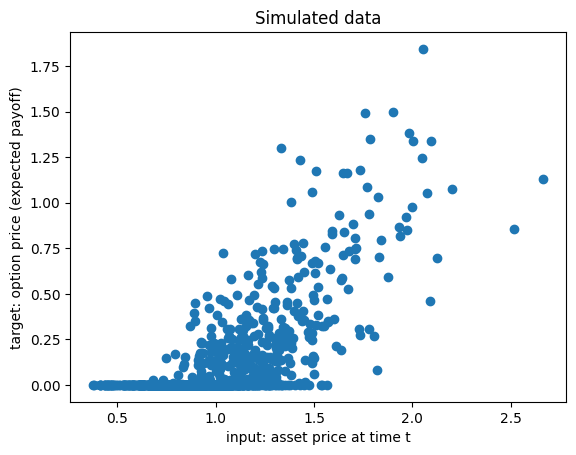

In [5]:
plt.scatter(x = asset_prices, y = payoffs)
plt.ylabel('target: option price (expected payoff)')
plt.xlabel('input: asset price at time t')
plt.title('Simulated data')

## **Feedforward network**

**Activation functions**

Activation functions are softplus.

$$ softplus(x) = log( 1+ exp(x) ) $$ 


The derivative of the softplus is 

$$ f'(x)= exp(x) / ( 1+ exp⁡(x) ) = 1 / ( 1 + exp(−x)),$$

 which is also called the logistic function.

Alternative activation function is the exponential linear unit (ELU). The ELU with $α > 0$ is

$$
f(x)=\left\{\begin{array}{ll}
x & \text { if } x>0 \\
\alpha(\exp (x)-1) & \text { if } x \leq 0
\end{array} \quad, \quad f^{\prime}(x)= \begin{cases}1 & \text { if } x>0 \\
f(x)+\alpha & \text { if } x \leq 0\end{cases}\right.
$$

The hyperparameter $α$ controls the value to which an ELU saturates for negative net inputs. ELUs diminish the vanishing gradient effect as rectified linear units (ReLUs) and leaky ReLUs do.

Reference: https://arxiv.org/pdf/1511.07289.pdf

In [6]:
### Create tf function to apply first derivative of ELU
@tf.function
def elu_deriv(x, alpha = 1.0): # alpha = 1 is default value
  pred = x > 0
  true_fn =  lambda: x
  false_fn = lambda: tf.keras.activations.elu(x, alpha = alpha) + alpha
  output = tf.cond(pred, true_fn, false_fn)
  return output 

# Test function
input_tensor = tf.Variable([[-1.0, 0.0, 1.0, 2.0]])
output_tensor = tf.map_fn(elu_deriv, tf.squeeze(input_tensor))
output_tensor

tf.reshape(output_tensor, [1, -1])
output_tensor


<tf.Tensor 'map/TensorArrayStack/TensorArrayGatherV3:0' shape=(4,) dtype=float32>

**TF functions**:

**tf.compat.v1.get_variable()**: creates a new variable and adds it to the TensorFlow graph. It takes an initial value as input and returns a TensorFlow variable object that can be used in subsequent computations.

**tf.placeholder()**: Inserts a placeholder for a tensor

**tf.keras.initializers.variance_scaling()**: used to initialise weights

**tf.zeros_initializer()**: initialises a tensor populated with zeros

**@ operator**: performs matrix multiplication

In [7]:
def vanilla_net(input_dim, hidden_units, hidden_layers, seed):          
    '''
    Input:
        input_dim       - dimension of inputs (1 in BS case) (data) [int]
        hidden_units    - units in hidden layers, assumed constant [int]
        hidden_layers   - number of hidden layers [int]
    Output:
        xs - inputs (asset prices)    [(n, input_dim) tf.Tensor] where n is # observations
        ws - weights                  [list of tf.Variables of length = (hidden_layers + 1), 1st element (input_dim, 1), last element (hidden_units, 1), others are (hidden_units, hidden_units)]
        bs - biases                   [list of tf.Variables of length = (hidden_layers + 1), last element (1, ), others are (hidden_units, )] 
        zs - layer outputs            [list of tf.Tensors of length = (hidden_layers + 2), 1st element = xs, second element = ys, others are (n, hidden_units)
        ys - prediction               [(n, 1) tf.Tensor] where n is # observations
  '''            
    # set seed
    #tf.random.set_seed(seed)
    
    # input layer (this will be the prices)
    #xs = tf.compat.v1.placeholder(shape=[None, input_dim], dtype=real_type) # for tf v1
    xs = tf.placeholder(shape=[None, input_dim], dtype=real_type)
       
    # connection weights and biases of hidden layers
    ws = [None]
    bs = [None]
    # layer 0 (input) has no parameters
    
    # layer 0 = input layer
    zs = [xs] # see equation 3), l=0
    
    # first hidden layer (index 1)
    # weight matrix
    ws.append(tf.get_variable("w1", [input_dim, hidden_units], \
        initializer = tf.variance_scaling_initializer(), dtype=real_type))
    # bias vector
    bs.append(tf.get_variable("b1", [hidden_units], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # graph
    zs.append(zs[0] @ ws[1] + bs[1]) # see equation 3), l=1
    
    # second hidden layer (index 2) to last (index hidden_layers)
    for l in range(1, hidden_layers): 
        ws.append(tf.get_variable("w%d"%(l+1), [hidden_units, hidden_units], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
        bs.append(tf.get_variable("b%d"%(l+1), [hidden_units], \
            initializer = tf.zeros_initializer(), dtype=real_type))
        # Softplus activation
        zs.append(tf.nn.softplus(zs[l]) @ ws[l+1] + bs[l+1]) # see equation 3), l=2..L-1
        # Elu activation
        #zs.append(tf.keras.activations.elu(zs[l], alpha = 1.0) @ ws[l+1] + bs[l+1])

    # output layer (index hidden_layers+1)
    ws.append(tf.compat.v1.get_variable("w"+str(hidden_layers+1), [hidden_units, 1], \
            initializer = tf.variance_scaling_initializer(), dtype=real_type))
    bs.append(tf.get_variable("b"+str(hidden_layers+1), [1], \
        initializer = tf.zeros_initializer(), dtype=real_type))
    # see equation 3), l=L
    # Softplus activation
    zs.append(tf.nn.softplus(zs[hidden_layers]) @ ws[hidden_layers+1] + bs[hidden_layers+1]) 
    # Elu activation
    #zs.append(tf.keras.activations.elu(zs[hidden_layers], alpha = 1.0) @ ws[hidden_layers+1] + bs[hidden_layers+1]) 
    
    # result = output layer
    ys = zs[hidden_layers+1]
    
    # return input layer, (parameters = weight matrices and bias vectors), 
    # [all layers] and output layer
    return xs, (ws, bs), zs, ys

In [8]:
# Test vanilla_net function
tf.reset_default_graph()
Xs, (Ws, Bs), Zs, Ys = vanilla_net(input_dim = 1 , hidden_units = 20, hidden_layers = 4, seed = None)

In [9]:
# Input shape
print(Xs.shape)

(?, 1)


In [45]:
# Weights dimension
Ws

[None,
 <tf.Variable 'w1:0' shape=(1, 20) dtype=float32_ref>,
 <tf.Variable 'w2:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'w3:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'w4:0' shape=(20, 20) dtype=float32_ref>,
 <tf.Variable 'w5:0' shape=(20, 1) dtype=float32_ref>]

In [48]:
# Biases dimension
Bs

[None,
 <tf.Variable 'b1:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'b2:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'b3:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'b4:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'b5:0' shape=(1,) dtype=float32_ref>]

In [31]:
# Hidden layers shape
Zs

[<tf.Tensor 'Placeholder:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'add:0' shape=(?, 20) dtype=float32>,
 <tf.Tensor 'add_1:0' shape=(?, 20) dtype=float32>,
 <tf.Tensor 'add_2:0' shape=(?, 20) dtype=float32>,
 <tf.Tensor 'add_3:0' shape=(?, 20) dtype=float32>,
 <tf.Tensor 'add_4:0' shape=(?, 1) dtype=float32>]

In [27]:
# Output shape
print(Ys.shape)

(?, 1)


**Back-prop and twin net**

In [10]:
# compute d_output/d_inputs by (explicit) backprop in vanilla net
def backprop(weights_and_biases, zs):                
    '''
      Input:
          weights_and_biases - 2nd output of vanilla_net(), input together as list
          zs                 - 3rd output of vanilla_net() 
      Output:
          xbar - predicted differentials   [(n, 1)) tf.Tensor] where n is # observations
    '''       
    ws, bs = weights_and_biases
    L = len(zs) - 1
    
    # backpropagation, see equation (4), l=L..1
    zbar = tf.ones_like(zs[L]) # zbar_L = 1
    for l in range(L-1, 0, -1):
        print(zs[l])
        # Softplus activation
        zbar = (zbar @ tf.transpose(ws[l+1])) * tf.nn.sigmoid(zs[l]) # see equation (4)
        print(zbar)
        # Elu activation
        #zbar = (zbar @ tf.transpose(ws[l+1])) * tf.reshape(tf.map_fn(elu_deriv, tf.squeeze(zs[l])), [1,-1])
    # for l=0
    zbar = zbar @ tf.transpose(ws[1]) # see equation (4)
    
    xbar = zbar # xbar = zbar_0
    
    # dz[L] / dx
    return xbar    


In [11]:
# Test backprop function
Xbar = backprop((Ws, Bs), Zs)

Tensor("add_3:0", shape=(?, 20), dtype=float32)
Tensor("mul:0", shape=(?, 20), dtype=float32)
Tensor("add_2:0", shape=(?, 20), dtype=float32)
Tensor("mul_1:0", shape=(?, 20), dtype=float32)
Tensor("add_1:0", shape=(?, 20), dtype=float32)
Tensor("mul_2:0", shape=(?, 20), dtype=float32)
Tensor("add:0", shape=(?, 20), dtype=float32)
Tensor("mul_3:0", shape=(?, 20), dtype=float32)


In [13]:
# Shape of output
Xbar

<tf.Tensor 'matmul_9:0' shape=(?, 1) dtype=float32>

In [15]:
# combined graph for valuation and differentiation
def twin_net(input_dim, hidden_units, hidden_layers, seed):
    '''
    This function combines the vanilla_net() and backprop() functions to build the twin network.
    
    Input:
        input_dim       - dimension of inputs (1 in BS case) (data) [int]
        hidden_units    - units in hidden layers, assumed constant [int]
        hidden_layers   - number of hidden layers [int]
        seed            - seed for reproducibility [int or None]
    Output:
        xs - inputs  (asset prices)             [(n, input_dim) tf.Tensor] where n is # observations
        ys - value prediction (option prices)   [(n, 1) tf.Tensor]
        xbar - predicted differentials          [(n, 1)) tf.Tensor] 

  '''     
    # first, build the feedforward net
    xs, (ws, bs), zs, ys = vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # then, build its differentiation by backprop
    xbar = backprop((ws, bs), zs)
    
    # return input x, output y and differentials d_y/d_z
    return xs, ys, xbar

In [19]:
# Test twin_net function
tf.reset_default_graph()
Xs, Ys, Xbar = twin_net(input_dim = 10, hidden_units = 20, hidden_layers = 4, seed = None)

Tensor("add_3:0", shape=(?, 20), dtype=float32)
Tensor("mul:0", shape=(?, 20), dtype=float32)
Tensor("add_2:0", shape=(?, 20), dtype=float32)
Tensor("mul_1:0", shape=(?, 20), dtype=float32)
Tensor("add_1:0", shape=(?, 20), dtype=float32)
Tensor("mul_2:0", shape=(?, 20), dtype=float32)
Tensor("add:0", shape=(?, 20), dtype=float32)
Tensor("mul_3:0", shape=(?, 20), dtype=float32)


In [24]:
# Inspect output
print(Xs, Ys, Xbar)

Tensor("Placeholder:0", shape=(?, 10), dtype=float32) Tensor("add_4:0", shape=(?, 1), dtype=float32) Tensor("matmul_9:0", shape=(?, 10), dtype=float32)


***Training***

In [25]:
def vanilla_training_graph(input_dim, hidden_units, hidden_layers, seed):
    '''
    This function builds the 'vanilla' training graph, where differential labels are NOT included
    It combines the vanilla_net() and backprop() functions to build the twin network, then defines the loss function, optimiser and learning rate.
    Loss is MSE and Adam is used as the optimiser.
   
    Input:
        input_dim       - dimension of inputs (1 in BS case) (data) [int]
        hidden_units    - units in hidden layers, assumed constant [int]
        hidden_layers   - number of hidden layers [int]
        seed            - seed for reproducibility [int or None]
    Output:
        xs                       - inputs (asset prices)                [(n, input_dim) tf.Tensor] where n is # observations
        labels                   - value targets (option prices)        [(n, 1) tf.Tensor]
        predictions              - value predictions (option prices)    [(n, 1) tf.Tensor]
        derivs_predictions       - differential predictions (deltas)    [(n, input_dim) tf.Tensor]
        learning_rate            - desired learning rate                ???
        loss                     - loss function
        optimizer.minimize(loss) -                                      [tf.Operation]
  '''     
    # net
    inputs, weights_and_biases, layers, predictions = \
        vanilla_net(input_dim, hidden_units, hidden_layers, seed)
    
    # backprop even though we are not USING differentials for training
    # we still need them to predict derivatives dy_dx 
    derivs_predictions = backprop(weights_and_biases, layers)
    
    # placeholder for labels
    labels = tf.compat.v1.placeholder(shape=[None, 1], dtype=real_type)
    
    # loss 
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    # optimizer
    learning_rate = tf.compat.v1.placeholder(real_type)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary 
    return inputs, labels, predictions, derivs_predictions, learning_rate, loss, optimizer.minimize(loss)

In [31]:
# Test vanilla_training_graph
tf.reset_default_graph()
Inputs, Labels, Preds, Derivs_preds, L_rate, Loss, Optimizer = vanilla_training_graph(input_dim = 2, hidden_units = 20, hidden_layers = 4, seed = None)

Tensor("add_3:0", shape=(?, 20), dtype=float32)
Tensor("mul:0", shape=(?, 20), dtype=float32)
Tensor("add_2:0", shape=(?, 20), dtype=float32)
Tensor("mul_1:0", shape=(?, 20), dtype=float32)
Tensor("add_1:0", shape=(?, 20), dtype=float32)
Tensor("mul_2:0", shape=(?, 20), dtype=float32)
Tensor("add:0", shape=(?, 20), dtype=float32)
Tensor("mul_3:0", shape=(?, 20), dtype=float32)


In [32]:
# Inspect output
print(Inputs, Labels, Preds, Derivs_preds)

Tensor("Placeholder:0", shape=(?, 2), dtype=float32) Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32) Tensor("add_4:0", shape=(?, 1), dtype=float32) Tensor("matmul_9:0", shape=(?, 2), dtype=float32)


In [37]:
# Inspect output
L_rate, Loss, Optimizer

(<tf.Tensor 'Placeholder_2:0' shape=<unknown> dtype=float32>,
 <tf.Tensor 'mean_squared_error/value:0' shape=() dtype=float32>,
 <tf.Operation 'Adam' type=NoOp>)

**session**:  In TensorFlow, a session is an environment for running computational graphs. It encapsulates the state of the TensorFlow runtime and allows you to execute operations and evaluate tensors. When you create and define a computational graph in TensorFlow, it represents the mathematical operations and relationships between tensors. However, just defining the graph does not execute any computations. To perform computations and evaluate tensors within the graph, you need to create a session.

In [ ]:
# training loop for one epoch
def vanilla_train_one_epoch(# training graph from vanilla_training_graph()
                            inputs, labels, lr_placeholder, minimizer,   
                            # training set 
                            x_train, y_train,                           
                            # params, left to client code
                            learning_rate, batch_size, session):        
    '''
    This function performs the training loop for one epoch by iterating over mini-batches of the training set
    For each mini-batch, it runs the optimizer to minimize the loss function using the current mini-batch. 
    The loop continues until all mini-batches have been processed for the given epoch.

    Input:
        inputs          - placeholder for input data 
        labels          - placeholder for labels/targets 
        lr_placeholder  - placeholder for learning rate
        minimizer       - optimizer used for minimizing the loss
        x_train         - training input data (asset prices)
        y_train         - training labels/targets (option prices)
        learning_rate   - Learning rate for optimization
        batch_size      - Size of mini-batches                           [int]
        session         - TensorFlow session for running computations
    Output:
        None
  ''' 

    # Define dimensions of the training set according to data inputs
    m, n = x_train.shape
    
    #### Minimization loop over mini-batches
    first = 0
    # For a given batch size and # of observations determine how many loops to run
    last = min(batch_size, m)
    while first < m:
        # session.run() call executes the minimizer operation with the given mini-batch of input data, labels, and learning rate.
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            lr_placeholder: learning_rate
        })
        # Update the indicies for the next mini batch
        first = last
        last = min(first + batch_size, m)

In [ ]:
# Let's try training one epoch of the vanilla NN


In [ ]:
# Define differential training graph (almost same as vanilla training graph)
def diff_training_graph(input_dim, hidden_units, hidden_layers, seed, alpha, beta, lambda_j):
    '''
    This function builds the differential training graph, where differential labels ARE included.
    It combines the twin_net() and backprop() functions to build the twin network, then defines the loss function, optimiser and learning rate.  
    loss = alpha * MSE(values) + beta * MSE(greeks, lambda_j), to balance relative weight of values and differentials (see appendix of paper).
    Adam is used as the optimiser.
    
    Input:
        input_dim       - dimension of inputs (1 in BS case) (data) [int]
        hidden_units    - units in hidden layers, assumed constant [int]
        hidden_layers   - number of hidden layers [int]
        seed            - seed for reproducibility [int or None]
        alpha           - weight on MSE for prediction values in loss function
        beta            - weight on MSE for prediction differentials in loss function (beta = 1 - alpha)
        lambda_j        -  (see normalize_data() function)
    Output:
        xs                       - inputs (asset prices)                [(n, input_dim) tf.Tensor] where n is # observations
        labels                   - value targets (option prices)        [(n, 1) tf.Tensor]
        predictions              - value predictions (option prices)    [(n, 1) tf.Tensor]
        derivs_predictions       - differential predictions (deltas)    [(n, input_dim) tf.Tensor]
        learning_rate            - desired learning rate                
        loss                     - Loss function
        optimizer.minimize(loss) -                                      [tf.Operation]
    '''     
    
    # net, now a twin inputs, predictions, derivs_predictions = twin_net(input_dim, hidden_units, hidden_layers, seed)
    
    # placeholder for labels, now also derivs labels
    labels = tf.compat.v1.placeholder(shape=[None, 1], dtype=real_type)
    derivs_labels = tf.compat.v1.placeholder(shape=[None, derivs_predictions.shape[1]], dtype=real_type)
    
    # loss, now combined values + derivatives
    loss = alpha * tf.losses.mean_squared_error(labels, predictions) \
    + beta * tf. losses.mean_squared_error(derivs_labels * lambda_j, derivs_predictions * lambda_j)
    
    # optimizer, as vanilla
    learning_rate = tf.compat.v1.placeholder(real_type)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
    
    # return all necessary tensors, including derivatives
    # predictions and labels
    return inputs, labels, derivs_labels, predictions, derivs_predictions, \
            learning_rate, loss, optimizer.minimize(loss)



In [40]:
# Define training loop for one epoch (same as vanilla_train_one_epoch() but with differential labels included)
def diff_train_one_epoch(inputs, labels, derivs_labels, lr_placeholder, minimizer, x_train, y_train, dydx_train, learning_rate, batch_size, session):    
    '''
    This function performs the training loop for one epoch by iterating over mini-batches of the training set
    For each mini-batch, it runs the optimizer to minimize the loss function using the current mini-batch. 
    The loop continues until all mini-batches have been processed for the given epoch.

    Input:
        inputs          - placeholder for input data 
        labels          - placeholder for labels/targets 
        derivs_labels   - placeholder for differential labels
        lr_placeholder  - placeholder for learning rate
        minimizer       - optimizer used for minimizing the loss
        x_train         - training input data (asset prices)
        y_train         - training labels/targets (option prices)
        learning_rate   - Learning rate for optimization
        batch_size      - Size of mini-batches                           [int]
        session         - TensorFlow session for running computations
    Output:
        None
  ''' 
    # Define dimensions of the training set according to data inputs
    m, n = x_train.shape
    
    #### Minimization loop over mini-batches, now with Greeks
    first = 0
    # For a given batch size and # of observations determine how many loops to run
    last = min(batch_size, m)
    while first < m:
        # session.run() call executes the minimizer operation with the given mini-batch of input data, labels, and learning rate.
        session.run(minimizer, feed_dict = {
            inputs: x_train[first:last], 
            labels: y_train[first:last],
            derivs_labels: dydx_train[first:last],
            lr_placeholder: learning_rate
        })
        # Update the indicies for the next mini batch
        first = last
        last = min(first + batch_size, m)

**Callbacks:**
A callback is a function that is called repeatedly during a process (for example the training of a neural network) and which generally serves to validate or correct certain behaviors. In machine learning, we can use callbacks to define what happens before, during, or at the end of a training epoch.
See: https://towardsdatascience.com/callbacks-in-neural-networks-b0b006df7626

In [ ]:
def train(description,
          # neural approximator
          approximator,              
          # training params
          reinit=True, 
          epochs=100, 
          # one-cycle learning rate schedule
          learning_rate_schedule= [    (0.0, 1.0e-8), \
                                      (0.2, 0.1),    \
                                      (0.6, 0.01),   \
                                      (0.9, 1.0e-6), \
                                      (1.0, 1.0e-8)  ], 
          batches_per_epoch=16,
          min_batch_size=256,
          # callback function and when to call it
          callback=None,           # arbitrary callable
          callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
    '''
    This function performs

    Input:
        description            - 
        approximator           - 
        reinit                 -
        epochs                 - number of epochs desired  [int]
        learning_rate_schedule - learning rate schedule    [list of 2 element tuples] 
                                                            - first element is epoch number on 0-1 scale
                                                            - second element is desired learning rate at that epoch
                                                            - intermediate values are linearly interpolated
                                                            - see following code cell for visualisation of default learning schedule
        batches_per_epoch      - number of mini batches per epoch [int]
        callback               - callback function to deploy (default = None) - can ignore
        callback_epochs=[]     - after which epochs should the callback function be called
    Output:
        None
  ''' 
          
    # batching - m is the number of observations
    batch_size = max(min_batch_size, approximator.m // batches_per_epoch)
    
    # one-cycle learning rate sechedule
    lr_schedule_epochs, lr_schedule_rates = zip(*learning_rate_schedule)
            
    # reset
    if reinit:
        approximator.session.run(approximator.initializer)
    
    # callback on epoch 0, if requested
    if callback and 0 in callback_epochs:
        callback(approximator, 0)
        
    # loop on epochs, with progress bar (tqdm)
    for epoch in tqdm_notebook(range(epochs), desc=description):
        
        # interpolate learning rate in cycle
        learning_rate = np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)
        
        # train one epoch
        
        if not approximator.differential:
        
            vanilla_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                learning_rate, 
                batch_size, 
                approximator.session)
        
        else:
        
            diff_train_one_epoch(
                approximator.inputs, 
                approximator.labels, 
                approximator.derivs_labels,
                approximator.learning_rate, 
                approximator.minimizer, 
                approximator.x, 
                approximator.y, 
                approximator.dy_dx,
                learning_rate, 
                batch_size, 
                approximator.session)
        
        # callback, if requested
        if callback and epoch in callback_epochs:
            callback(approximator, epoch)

    # final callback, if requested
    if callback and epochs in callback_epochs:
        callback(approximator, epochs)        

(0.0, 0.2, 0.6, 0.9, 1.0) (1e-08, 0.1, 0.01, 1e-06, 1e-08)


Text(0.5, 1.0, 'Learning Rate Schedule')

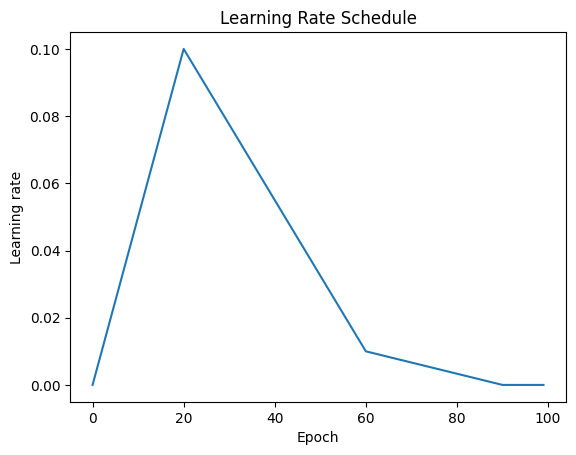

In [51]:
# Inspect learning rate schedule
learning_rate_schedule = [ (0.0, 1.0e-8), (0.2, 0.1), (0.6, 0.01), (0.9, 1.0e-6), (1.0, 1.0e-8)]

lr_schedule_epochs, lr_schedule_rates = zip(*learning_rate_schedule)

learning_rates = np.zeros(epochs)

for epoch in range(0, epochs):
  learning_rates[epoch] = np.interp(epoch / epochs, lr_schedule_epochs, lr_schedule_rates)

plt.plot(range(0,100), learning_rates) 
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning Rate Schedule')

***Normalise data***

In [ ]:
# basic data preparation
epsilon = 1.0e-08
def normalize_data(x_raw, y_raw, dydx_raw=None, crop=None):
    
    # crop dataset
    m = crop if crop is not None else x_raw.shape[0]
    x_cropped = x_raw[:m]
    y_cropped = y_raw[:m]
    dycropped_dxcropped = dydx_raw[:m] if dydx_raw is not None else None
    
    # normalize dataset
    x_mean = x_cropped.mean(axis=0)
    x_std = x_cropped.std(axis=0) + epsilon
    x = (x_cropped- x_mean) / x_std
    y_mean = y_cropped.mean(axis=0)
    y_std = y_cropped.std(axis=0) + epsilon
    y = (y_cropped-y_mean) / y_std
    
    # normalize derivatives too
    if dycropped_dxcropped is not None:
        dy_dx = dycropped_dxcropped / y_std * x_std 
        # weights of derivatives in cost function = (quad) mean size
        lambda_j = 1.0 / np.sqrt((dy_dx ** 2).mean(axis=0)).reshape(1, -1)
    else:
        dy_dx = None
        lambda_j = None
    
    return x_mean, x_std, x, y_mean, y_std, y, dy_dx, lambda_j

**Putting everything together**

In [ ]:
class Neural_Approximator():
    
    def __init__(self, x_raw, y_raw, 
                 dydx_raw=None):      # derivatives labels, 
       
        self.x_raw = x_raw
        self.y_raw = y_raw
        self.dydx_raw = dydx_raw
        
        # tensorflow logic
        self.graph = None
  #      self.session = None
                        
    #def __del__(self):
    #    if self.session is not None:
    #        self.session.close()
        
    def build_graph(self,
                differential,       # differential or not           
                lam,                # balance cost between values and derivs  
                hidden_units, 
                hidden_layers, 
                weight_seed):
        
        # first, deal with tensorflow logic
     #   if self.session is not None:
     #       self.session.close()

        self.graph = tf.Graph()
        
        with self.graph.as_default():
        
            # build the graph, either vanilla or differential
            self.differential = differential
            
            if not differential:
            # vanilla 
                
                self.inputs, \
                self.labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer \
                = vanilla_training_graph(self.n, hidden_units, hidden_layers, weight_seed)
                    
            else:
            # differential
            
                if self.dy_dx is None:
                    raise Exception("No differential labels for differential training graph")
            
                self.alpha = 1.0 / (1.0 + lam * self.n)
                self.beta = 1.0 - self.alpha
                
                self.inputs, \
                self.labels, \
                self.derivs_labels, \
                self.predictions, \
                self.derivs_predictions, \
                self.learning_rate, \
                self.loss, \
                self.minimizer = diff_training_graph(self.n, hidden_units, \
                                                     hidden_layers, weight_seed, \
                                                     self.alpha, self.beta, self.lambda_j)
        
            # global initializer
            self.initializer = tf.compat.v1.global_variables_initializer()
            
        # done
        self.graph.finalize()
        self.session = tf.compat.v1.Session(graph=self.graph)
                        
    # prepare for training with m examples, standard or differential
    def prepare(self, 
                m, 
                differential,
                lam=1,              # balance cost between values and derivs  
                # standard architecture
                hidden_units=20, 
                hidden_layers=4, 
                weight_seed=None):

        # prepare dataset
        self.x_mean, self.x_std, self.x, self.y_mean, self.y_std, self.y, self.dy_dx, self.lambda_j = \
            normalize_data(self.x_raw, self.y_raw, self.dydx_raw, m)
        
        # build graph        
        self.m, self.n = self.x.shape        
        self.build_graph(differential, lam, hidden_units, hidden_layers, weight_seed)
        
    def train(self,            
              description="training",
              # training params
              reinit=True, 
              epochs=100, 
              # one-cycle learning rate schedule
              learning_rate_schedule=[
                  (0.0, 1.0e-8), 
                  (0.2, 0.1), 
                  (0.6, 0.01), 
                  (0.9, 1.0e-6), 
                  (1.0, 1.0e-8)], 
              batches_per_epoch=16,
              min_batch_size=256,
              # callback and when to call it
              # we don't use callbacks, but this is very useful, e.g. for debugging
              callback=None,           # arbitrary callable
              callback_epochs=[]):     # call after what epochs, e.g. [5, 20]
              
        train(description, 
              self, 
              reinit, 
              epochs, 
              learning_rate_schedule, 
              batches_per_epoch, 
              min_batch_size,
              callback, 
              callback_epochs)
     
    def predict_values(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std 
        # predict scaled
        y_scaled = self.session.run(self.predictions, feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        return y

    def predict_values_and_derivs(self, x):
        # scale
        x_scaled = (x-self.x_mean) / self.x_std
        # predict scaled
        y_scaled, dyscaled_dxscaled = self.session.run(
            [self.predictions, self.derivs_predictions], 
            feed_dict = {self.inputs: x_scaled})
        # unscale
        y = self.y_mean + self.y_std * y_scaled
        dydx = self.y_std / self.x_std * dyscaled_dxscaled
        return y, dydx

***Implementation***

In [ ]:
def test(generator, 
         sizes, 
         nTest, 
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    xTrain, yTrain, dydxTrain = generator.trainingSet(max(sizes), seed=simulSeed)
    xTest, xAxis, yTest, dydxTest, vegas = generator.testSet(num=nTest, seed=testSeed)
    print("done")

    # neural approximator
    print("initializing neural appropximator")
    regressor = Neural_Approximator(xTrain, yTrain, dydxTrain)
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    for size in sizes:        
            
        print("\nsize %d" % size)
        regressor.prepare(size, False, weight_seed=weightSeed)

        t0 = time.time()
        regressor.train("standard training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("standard", size)] = predictions
        preddeltas[("standard", size)] = deltas[:, deltidx]
        t1 = time.time()
        
        regressor.prepare(size, True, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("differential training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("differential", size)] = predictions
        preddeltas[("differential", size)] = deltas[:, deltidx]
        t1 = time.time()
        
    return xAxis, yTest, dydxTest[:, deltidx], vegas, predvalues, preddeltas

def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          sizes, 
          computeRmse=False, 
          weights=None):
    
    numRows = len(sizes)
    numCols = 2

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title("Standard")
    ax[0,1].set_title("Differential")
    
    for i, size in enumerate(sizes):        
        for j, regType, in enumerate(["standard", "differential"]):

            if computeRmse:
                errors = 100 * (predictions[(regType, size)] - targets)
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.2f" % rmse
                #t = 'asset price'
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle("% s -- %s" % (title, yAxisName), fontsize=16)
    plt.show()

In [ ]:
# simulation set sizes to perform
sizes = [1000, 1000000]

# show delta?
showDeltas = True

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
weightSeed = None

# number of test scenarios
nTest = 100    

# go
generator = BlackScholes()
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 1788
simulating training, valid and test sets
done
initializing neural appropximator
done

size 1000
Tensor("add_3:0", shape=(None, 20), dtype=float32)
Tensor("mul:0", shape=(None, 20), dtype=float32)
Tensor("add_2:0", shape=(None, 20), dtype=float32)
Tensor("mul_1:0", shape=(None, 20), dtype=float32)
Tensor("add_1:0", shape=(None, 20), dtype=float32)
Tensor("mul_2:0", shape=(None, 20), dtype=float32)
Tensor("add:0", shape=(None, 20), dtype=float32)
Tensor("mul_3:0", shape=(None, 20), dtype=float32)


<ipython-input-15-6d9515185a71>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), desc=description):


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

Tensor("add_3:0", shape=(None, 20), dtype=float32)
Tensor("mul:0", shape=(None, 20), dtype=float32)
Tensor("add_2:0", shape=(None, 20), dtype=float32)
Tensor("mul_1:0", shape=(None, 20), dtype=float32)
Tensor("add_1:0", shape=(None, 20), dtype=float32)
Tensor("mul_2:0", shape=(None, 20), dtype=float32)
Tensor("add:0", shape=(None, 20), dtype=float32)
Tensor("mul_3:0", shape=(None, 20), dtype=float32)


differential training:   0%|          | 0/100 [00:00<?, ?it/s]


size 1000000
Tensor("add_3:0", shape=(None, 20), dtype=float32)
Tensor("mul:0", shape=(None, 20), dtype=float32)
Tensor("add_2:0", shape=(None, 20), dtype=float32)
Tensor("mul_1:0", shape=(None, 20), dtype=float32)
Tensor("add_1:0", shape=(None, 20), dtype=float32)
Tensor("mul_2:0", shape=(None, 20), dtype=float32)
Tensor("add:0", shape=(None, 20), dtype=float32)
Tensor("mul_3:0", shape=(None, 20), dtype=float32)


standard training:   0%|          | 0/100 [00:00<?, ?it/s]

Tensor("add_3:0", shape=(None, 20), dtype=float32)
Tensor("mul:0", shape=(None, 20), dtype=float32)
Tensor("add_2:0", shape=(None, 20), dtype=float32)
Tensor("mul_1:0", shape=(None, 20), dtype=float32)
Tensor("add_1:0", shape=(None, 20), dtype=float32)
Tensor("mul_2:0", shape=(None, 20), dtype=float32)
Tensor("add:0", shape=(None, 20), dtype=float32)
Tensor("mul_3:0", shape=(None, 20), dtype=float32)


differential training:   0%|          | 0/100 [00:00<?, ?it/s]

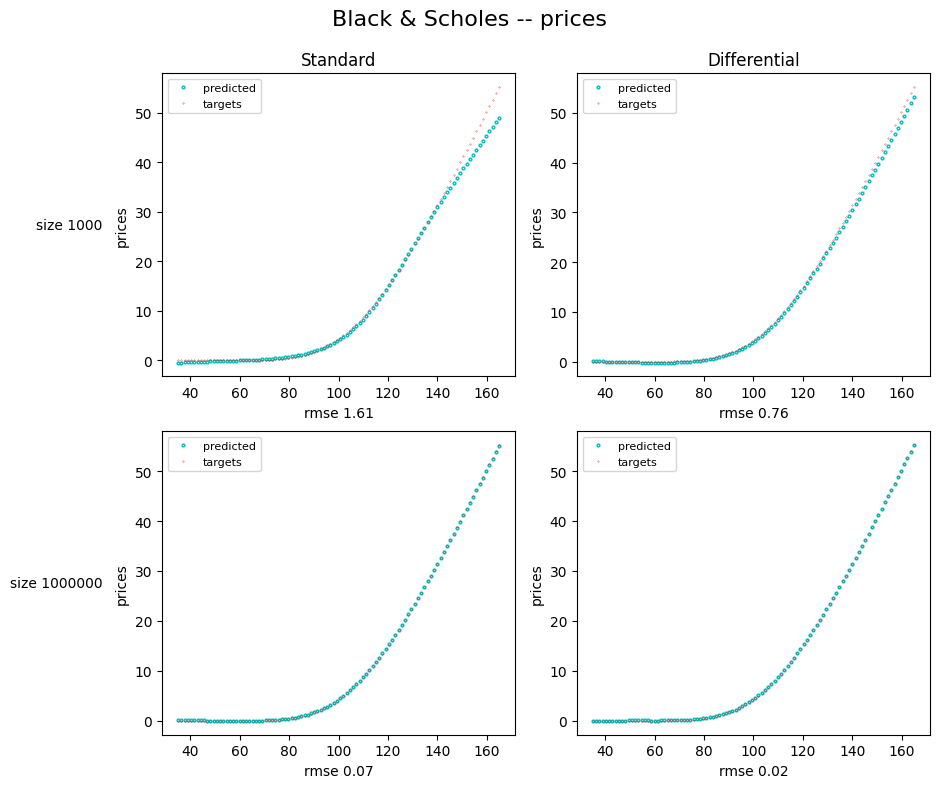

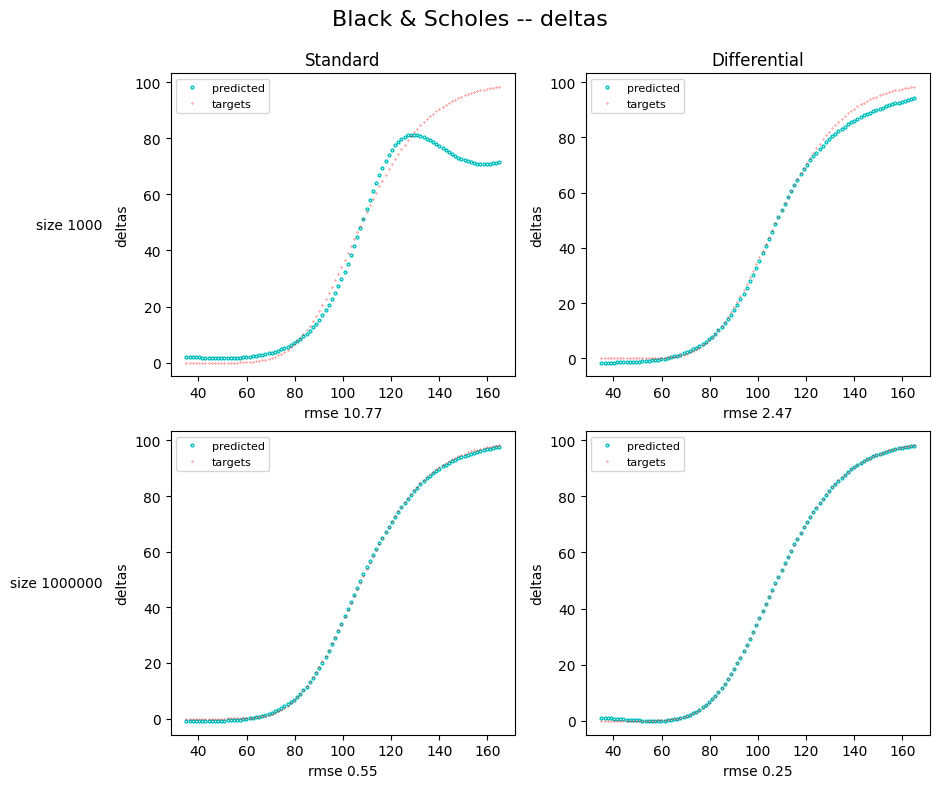

In [ ]:
# show predicitions
graph("Black & Scholes", values, xAxis, "", "prices", yTest, sizes, True)

# show deltas
graph("Black & Scholes", deltas, xAxis, "", "deltas", dydxTest, sizes, True)

In [ ]:
xAxis, yTest, dydxTest, vegas, values, deltas

In [ ]:
### Function to compute RMSE
def computeRmse(pred, true):
  errors = 100*(pred - true)
  rmse = np.sqrt((errors ** 2)).mean()
  return(rmse)

0.17779828174333415
0.5990752921945638


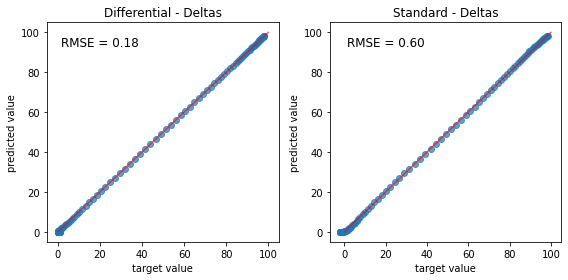

In [ ]:
### Plot results - Deltas
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axs[0].scatter(x = deltas[('differential', 1000000)]*100, y = dydxTest*100, alpha = 0.7)
axs[0].plot([0, 100], [0, 100], color='red', alpha = 0.6)
axs[0].set_ylabel('predicted value')
axs[0].set_xlabel('target value')
axs[0].set_title('Differential - Deltas')
axs[0].text(20, 95, 'RMSE = 0.18', fontsize=12, ha='center', va='center')

axs[1].scatter(x = deltas[('standard', 1000000)]*100, y = dydxTest*100, alpha = 0.7)
axs[1].plot([0, 100], [0, 100], color='red', alpha = 0.6)
axs[1].set_ylabel('predicted value')
axs[1].set_xlabel('target value')
axs[1].set_title('Standard - Deltas')
axs[1].text(20, 95, 'RMSE = 0.60', fontsize=12, ha='center', va='center')

print(computeRmse(deltas[('differential', 1000000)], dydxTest))
print(computeRmse(deltas[('standard', 1000000)], dydxTest))


# Adjust the spacing between the plots
fig.tight_layout()

# Display the plots
plt.show()

0.05741148659843286
0.0171768543143316


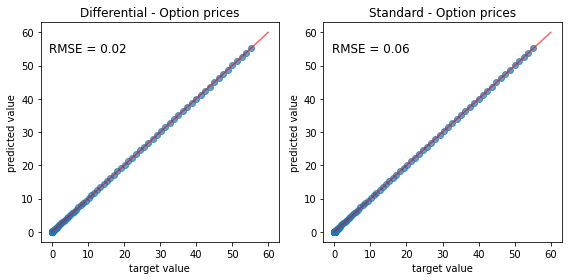

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

### Plot results - Option prices
axs[0].scatter(x = values[('differential', 1000000)]*100, y = yTest*100, alpha = 0.7)
axs[0].plot([0, 60], [0, 60], color='red', alpha = 0.6)
axs[0].set_ylabel('predicted value')
axs[0].set_xlabel('target value')
axs[0].set_title('Differential - Option prices')
axs[0].text(10, 55, 'RMSE = 0.02', fontsize=12, ha='center', va='center')


axs[1].scatter(x = values[('standard', 1000000)]*100, y = yTest*100, alpha = 0.7)
axs[1].plot([0, 60], [0, 60], color='red', alpha = 0.6)
axs[1].set_ylabel('predicted value')
axs[1].set_xlabel('target value')
axs[1].set_title('Standard - Option prices')
axs[1].text(10, 55, 'RMSE = 0.06', fontsize=12, ha='center', va='center')

print(computeRmse(values[('standard', 1000000)], yTest))
print(computeRmse(values[('differential', 1000000)], yTest))

# Adjust the spacing between the plots
fig.tight_layout()

# Display the plots
plt.show()
